# Install

In [70]:
!pip install rdkit
#!pip install tensorflow
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install pytorch-lightning

Looking in indexes: https://download.pytorch.org/whl/cu118


# Import

In [71]:
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
import time

# Machine Learning
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def RF(x_train, y_train):
    # Define the parameter grid for GridSearchCV
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_features': [None,'sqrt', 'log2'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Create a GridSearchCV object
    rf = RandomForestRegressor(random_state=42)
    #return rf
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)  # Adjust number of splits as needed

    random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=kfold, verbose=1, scoring='neg_mean_squared_error')

    # Fit the GridSearchCV object
    random_search.fit(x_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_
    print(random_search.best_params_)

    return best_model

def XGB(x_train, y_train):
    # Define the parameter grid for RandomizedSearchCV
    param_dist = {
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300, 400]
    }

    # Create a RandomizedSearchCV object
    xgb = XGBRegressor(random_state=42)
    #return xgb
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust number of splits as needed

    random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, cv=kfold, verbose=1,
                                       scoring='neg_mean_squared_error')

    # Fit the RandomizedSearchCV object
    random_search.fit(x_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_
    print(random_search.best_params_)

    return best_model

def SVR_M(x_train, y_train):
    # Define the parameter grid for RandomizedSearchCV
    param_dist = {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': np.logspace(-3, 3, 7),
        'epsilon': [0.1, 0.2, 0.5, 0.01]
    }

    # Create a RandomizedSearchCV object
    svr = SVR()
    #return svr
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust number of splits as needed

    random_search = RandomizedSearchCV(svr, param_distributions=param_dist, n_iter=10, cv=kfold, verbose=1, scoring='neg_mean_squared_error')

    # Fit the RandomizedSearchCV object
    random_search.fit(x_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_
    print(random_search.best_params_)

    return best_model


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam

#import pytorch_lightning as L
from torch.utils.data import TensorDataset, DataLoader
class FCN(nn.Module):

    def __init__(self, N_Input, N_Output, N_Hidden, N_Layer):
      super().__init__()
      activation = nn.Tanh
      self.fcs = nn.Sequential(*[
          nn.Linear(N_Input, N_Hidden),
          activation()])
      self.fch = nn.Sequential(*[
                  nn.Sequential(*[
                    nn.Linear(N_Hidden, N_Hidden),
                    activation()]) for _ in range(N_Layer-1)])
      self.fce = nn.Linear(N_Hidden, N_Output)

      self.learning_rate = 0.01

    def forward(self, input):
      x = self.fcs(input)
      x = self.fch(x)
      x = self.fce(x)
      return x

def DL(x_train, y_train):
    temp_tensor = x_train[x_train.shape[1]-1].reset_index(drop=True)

    x_train = x_train.drop(columns=x_train.shape[1]-1)
    inputs = torch.tensor(x_train.values)
    labels = torch.tensor(y_train.values)

    dataset = TensorDataset(inputs, labels)
    dataloader = DataLoader(dataset)

    model = FCN(x_train.shape[1], 1, 200, 3)
    optimizer = Adam(model.parameters(), lr=0.001)

    for epoch in range(50):
      total_loss = 0

      for iteration in range(len(inputs)):
        #print(iteration)
        input_i = inputs[iteration]

        temp_i = torch.tensor(temp_tensor[iteration])
        label_i = labels[iteration]

        #print(label_i)
        output_i = model(input_i)
        loss = sum((output_i - label_i)**2)

        #Psat_pre = Psat_cal(temp_i, output_i[0], output_i[1], output_i[2])
        #Psat_an = Psat_cal(temp_i, label_i[0], label_i[1], label_i[2])
        #loss2 = (Psat_an - Psat_pre)**2

        loss_all = loss
        #print(f"loss1 : {loss}  loss2: {loss2}")
        loss_all.backward()

        total_loss += float(loss)

      optimizer.step()
      optimizer.zero_grad()

      if(epoch%5 == 0):
        print(f"Step: {epoch} , output : {output_i.detach().numpy()},  loss : {loss_all}")

    '''
    model = Sequential()
    model.add(Dense(2048, input_dim=x_train.shape[1] , activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
    '''
    return model
def DL2(x_train, y_train):
    temp_tensor = x_train[x_train.shape[1]-1].reset_index(drop=True)

    x_train = x_train.drop(columns=x_train.shape[1]-1)
    inputs = torch.tensor(x_train.values)
    labels = torch.tensor(y_train.values)

    dataset = TensorDataset(inputs, labels)
    dataloader = DataLoader(dataset)

    model = FCN(x_train.shape[1], 1, 1000, 4)
    optimizer = Adam(model.parameters(), lr=0.001)

    for epoch in range(50):
      total_loss = 0

      for iteration in range(len(inputs)):
        #print(iteration)
        input_i = inputs[iteration]

        temp_i = torch.tensor(temp_tensor[iteration])
        label_i = labels[iteration]

        #print(label_i)
        output_i = model(input_i)
        loss = sum((output_i - label_i)**2)

        #Psat_pre = output_i
        #Psat_an = Psat_cal(temp_i, label_i[0], label_i[1], label_i[2])
        #loss2 = (Psat_an - Psat_pre)**2

        loss_all = loss
        #loss_all = loss + 10**(loss2) *10
        #print(f"loss1 : {loss}  loss2: {loss2}")
        loss_all.backward()

        total_loss += float(loss)

      optimizer.step()
      optimizer.zero_grad()

      if(epoch%5 == 0):
        print(f"Step: {epoch} , output : {output_i.detach().numpy()},  loss : {loss_all}")

    '''
    model = Sequential()
    model.add(Dense(2048, input_dim=x_train.shape[1] , activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
    '''
    return model

In [72]:
# %% Package
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

# Our module
#from Python_MLModel import RF, Ridge_M, XGB, NN, DT, SVR_M, KNN
#from Python_Scoring_Export import Scoring, Export

def Psat_cal(T,A,B,C):
    #return pow(A-(B/(T+C)),10)/(10^(3))
    return A-(B/(T+C))
def generateTemp(Tmin, Tmax, amountpoint):
    numbers = np.linspace(Tmin, Tmax, amountpoint)
    print(Tmin)
    return numbers
    #step_size = (Tmax - Tmin)/(amountpoint - 1)

    #Trange = Tmax-Tmin
    T_arr =[]
    for i in range(len(Tmin)):

        #print(numbers)
        T_arr.append(numbers)
    return T_arr

# Work

In [73]:
!git clone https://github.com/Sawahiko/SMILE_to_Feature

fatal: destination path 'SMILE_to_Feature' already exists and is not an empty directory.


In [74]:
#%% Import Data
!git clone https://github.com/Sawahiko/SMILE_to_Feature
df = pd.read_csv("/content/SMILE_to_Feature/Second Semester/[Use] Main File/New_Data_Psat_Not_Outliers.csv")
df = df[df['SMILES'] != "None"].reset_index(drop=True)
df.sort_values(by="No.C")

fatal: destination path 'SMILE_to_Feature' already exists and is not an empty directory.


,Unnamed: 0,Name,SMILES,A,B,C,Tmin,Tmax,No.C
0,0,Methanal,C=O,21.370292,2204.126554,-30.150,190,271,1
36,36,Formamide,C(=O)N,23.311763,5274.025104,-44.106,391,466,1
30,30,Hydrogen cyanide,C#N,21.886463,2886.895994,-20.307,261,300,1
29,29,Methanamine,CN,21.976333,2419.234054,-35.320,203,288,1
1543,1543,Methyl diazene,CN=N,23.568524,3308.561494,0.000,195,236,1
...,...,...,...,...,...,...,...,...,...
1776,1776,"4-Ethyl-2,6-dimethyloctane",CCC(C)CC(CC)CC(C)C,20.181583,3271.766184,-85.150,463,463,12
1777,1777,"3-Ethyl-2,7-dimethyloctane",CCC(CCCC(C)C)C(C)C,20.161320,3298.660378,-87.150,469,469,12
1778,1778,"4-Ethyl-2,7-dimethyloctane",CCC(CCC(C)C)CC(C)C,20.181583,3271.766184,-85.150,463,463,12
1268,1268,trans-6-Dodecene,CCCCC/C=C/CCCCC,20.482162,3391.194366,-107.729,437,487,12


In [75]:
df1 = df.copy()

# Function to generate equally distributed points
def generate_points(row):
    start, end, num_points = row["Tmin"], row["Tmax"], 5
    step_size = (end - start) / (num_points - 1)
    return np.linspace(start, end, num_points)

# Apply the function to each row and create a new column
df1["T"] = df1.apply(generate_points, axis=1)

#T_Test = generateTemp(df1["Tmin"], df1["Tmax"], 5)
#T_all = []
#for i in range(len(T_Test[0])):
#    T_gen_x_point = [item[i] for item in T_Test]
#    T_all.append(T_gen_x_point)
#
#df1["T"] = T_Test


df1  = df1.explode('T')
df1['T'] = df1['T'].astype('float32')
#df1 = df1.drop(columns={"Column1"})
df1 = df1.reset_index(drop=True)



Psat_test = Psat_cal(df1["T"], df1["A"], df1["B"], df1["C"])
df1["Vapor_Presssure"] = Psat_test

df2 = df1[["SMILES", "T", "Vapor_Presssure"]]
# Select feature for data: X=SMILE, Y=Tb
X_data_excel= df2[["SMILES"]]
Y_data= df2["Vapor_Presssure"]

In [76]:
# %% Fingerprint
# Generate Fingerprint from SMILE
MF_radius = 3
MF_bit = 4096

X_data_use = X_data_excel.copy()
X_data_use["molecule"] = X_data_use["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
X_data_use["count_morgan_fp"] = X_data_use["molecule"].apply(lambda x: rdMolDescriptors.GetHashedMorganFingerprint(
    x,
    radius=MF_radius,
    nBits=MF_bit,
    useFeatures=True, useChirality=True))
X_data_use["arr_count_morgan_fp"] = 0
#X_data_use["arr_count_morgan_fp"] = np.zeros((0,), dtype=np.int8)

#X_data_use["arr_count_morgan_fp"]
#new_df = X_data_use.apply(DataStructs.ConvertToNumpyArray, axis=0, args=('count_morgan_fp',))


# Transfrom Fingerprint to Column in DataFrame
X_data_fp = []
for i in range(X_data_use.shape[0]):
    #print(np.array(X_data_use["morgan_fp"][i]))
    blank_arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(X_data_use["count_morgan_fp"][i],blank_arr)
    datafram_i = pd.DataFrame(blank_arr)
    datafram_i = datafram_i.T
    X_data_fp.append(datafram_i)
x_data_fp = pd.concat(X_data_fp, ignore_index=True)
x_data_fp = x_data_fp.astype(np.float32)
y_data_fp = Y_data.copy()

In [77]:
# %% MinMaxScaler
#x_data_fp = df2[["Temp_test"]].join(x_data_fp)
x_data_fp[MF_bit] = df2["T"]

"""
from sklearn.preprocessing import MinMaxScaler
# Define the scaler for the last column
scaler_col3 = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data
scaler_col3.fit(x_data_fp[MF_bit].values.reshape(-1, 1))

# Transform the data using the fitted scaler
x_data_fp[MF_bit] = scaler_col3.transform(x_data_fp[MF_bit].values.reshape(-1, 1))
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\n# Define the scaler for the last column\nscaler_col3 = MinMaxScaler(feature_range=(0, 1))\n\n# Fit the scaler to the data\nscaler_col3.fit(x_data_fp[MF_bit].values.reshape(-1, 1))\n\n# Transform the data using the fitted scaler\nx_data_fp[MF_bit] = scaler_col3.transform(x_data_fp[MF_bit].values.reshape(-1, 1))\n'

In [78]:
#%% Train-test split
x_train_fp, x_test_fp, y_train_fp, y_test_fp = train_test_split(x_data_fp, y_data_fp,test_size=0.2,random_state=42)

In [79]:
models = []


In [80]:
#%% Training Model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

def model_assess(X_train, X_test, y_train, y_test, list_model, name_model, title = "Default"):
  model_assess_table = pd.DataFrame(['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2']).transpose()
  new_header = model_assess_table.iloc[0] #grab the first row for the header
  model_assess_table.columns = new_header #set the header row as the df header
  model_assess_table.drop(index=model_assess_table.index[0], axis=0, inplace=True)

  train_prediction_table = pd.DataFrame(['Method','Training Predict','Training Actual']).transpose()
  new_header = train_prediction_table.iloc[0] #grab the first row for the header
  train_prediction_table.columns = new_header #set the header row as the df header
  train_prediction_table.drop(index=train_prediction_table.index[0], axis=0, inplace=True)

  test_prediction_table = pd.DataFrame(['Method','Test Predict','Test Actual']).transpose()
  new_header = test_prediction_table.iloc[0] #grab the first row for the header
  test_prediction_table.columns = new_header #set the header row as the df header
  test_prediction_table.drop(index=test_prediction_table.index[0], axis=0, inplace=True)

  for iteration in range(len(list_model)):
      model = list_model[iteration]
      name = name_model[iteration]
      if("DL" not in name):
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)
      else:
        X_train_drop = X_train.drop(columns=X_train.shape[1]-1)
        X_test_drop = X_test.drop(columns=X_test.shape[1]-1)
        y_train_pred = model(torch.tensor(X_train_drop.values)).detach().numpy()
        y_test_pred  = model(torch.tensor(X_test_drop.values)).detach().numpy()

      train_mae = mean_absolute_error(y_train, y_train_pred)
      train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
      train_r2 = r2_score(y_train, y_train_pred)
      test_mae = mean_absolute_error(y_test, y_test_pred)
      test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
      test_r2 = r2_score(y_test, y_test_pred)

      results = pd.DataFrame([name_model[iteration],train_mae, train_rmse, train_r2, test_mae, test_rmse, test_r2]).transpose()
      results.columns = ['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2']

      train_prediction_result = pd.DataFrame([name_model[iteration],y_train_pred, y_train]).transpose()
      train_prediction_result.columns = ['Method','Training Predict','Training Actual']

      test_prediction_result = pd.DataFrame([name_model[iteration], y_test_pred, y_test]).transpose()
      test_prediction_result.columns = ['Method','Test Predict','Test Actual']

      model_assess_table = pd.concat([model_assess_table, results])
      train_prediction_table = pd.concat([train_prediction_table, train_prediction_result])
      test_prediction_table = pd.concat([test_prediction_table, test_prediction_result])
  return model_assess_table, train_prediction_table, test_prediction_table

## Set up

In [81]:
all_result_model = []
#names = ["XGB", "RF", "SVM"]
names = ["XGB", "RF", "DL1", "DL2"]
#models = [XGB, RF, SVR_M]
models = [XGB, RF, DL, DL2 ]
for iteration in range(len(names)) :
    get_model = models[iteration]
    result_model = get_model(x_train_fp, y_train_fp)
    all_result_model.append(result_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01}
Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}
Step: 0 , output : [-0.01332131],  loss : 133.08094787597656
Step: 5 , output : [2.4057927],  loss : 83.11893463134766
Step: 10 , output : [7.165239],  loss : 18.987911224365234
Step: 15 , output : [9.389733],  loss : 4.5497636795043945
Step: 20 , output : [10.450192],  loss : 1.1503815650939941
Step: 25 , output : [11.19778],  loss : 0.10560628026723862
Step: 30 , output : [11.596384],  loss : 0.005421847105026245
Step: 35 , output : [11.63014],  loss : 0.011532493866980076
Step: 40 , output : [11.41879],  loss : 0.010807887651026249
Step: 45 , output : [11.126359],  loss : 0.1571265161037445
Step: 0 , output : [0.01198744],  loss : 132.49766540527344
Step: 5 , output : [13.5847225],  loss : 4.2517

In [82]:
result_evaluation, train_prediction, test_prediction = model_assess(x_train_fp, x_test_fp, y_train_fp, y_test_fp, all_result_model, names)
result_evaluation = result_evaluation.reset_index(drop=True)
train_prediction = train_prediction.reset_index(drop=True).explode(['Training Predict', 'Training Actual'])
test_prediction = test_prediction.reset_index(drop=True).explode(['Test Predict', 'Test Actual'])

In [83]:
x_train_fp[4096]
y_train_fp.shape

(7636,)

In [84]:
all_result_model

[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 RandomForestRegressor(max_depth=10, max_features=None, min_samples_split=5,
                       n_estimators=50, random_state=42),
 FCN(
   (fcs): Sequential(
     (0): Linear(in_features=4096, out_features=200, bias=True)
     (1): Tanh()
   

In [85]:
result_evaluation

,Method,Training MAE,Training RMSE,Training R2,Test MAE,Test RMSE,Test R2
0,XGB,2.521142,50.781045,0.513974,5.455432,117.949447,-0.197928
1,RF,0.807774,9.772171,0.982001,1.25083,18.607227,0.970187
2,DL1,2.965077,72.528223,0.008551,4.133816,107.820866,-0.001024
3,DL2,2.680809,72.339614,0.013701,4.02669,107.423134,0.006348


In [86]:
def checknum(x):
  if(isinstance(x, list)):
    return x[0]
  elif(isinstance(x, object)):
    return x.astype(float)
  else:
    return x
def checktype(x):
  '''
  if isinstance(x, list):
    return 1
  elif isinstance(x, object):
    return 2
  elif isinstance(x, float):
    return 3
  else:
    return 4
  '''
  return float(x)
#test_prediction2 = test_prediction.copy()
#test_prediction2['Test Predict'] = test_prediction2['Test Predict'].apply(lambda x: checktype(x))

test_prediction['Test Predict'] = test_prediction['Test Predict'].apply(lambda x: checktype(x))
train_prediction['Training Predict'] = train_prediction['Training Predict'].apply(lambda x: checktype(x))

In [87]:
test_prediction.shape[0]/4

1909.0

In [88]:
train_prediction.shape[0]/4

7636.0

(-4718.95440773, 35.12905464172529)

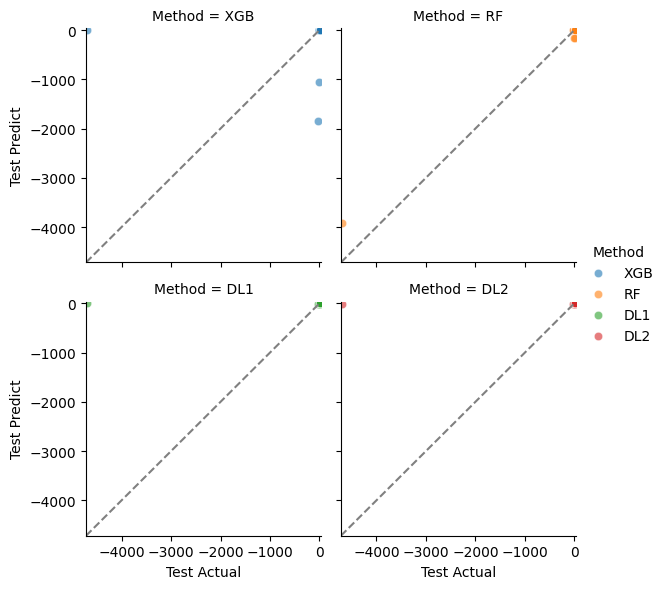

In [89]:
  #%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = min(min(test_prediction["Test Predict"]),min(test_prediction["Test Actual"]))-20
x_max = max(max(test_prediction["Test Predict"]),max(test_prediction["Test Actual"]))+20
y_min, y_max = x_min, x_max


#width = 6; height = 6  # Define desired figure width and height in inches
#plt.figure(figsize=(width, height)) # Create the figure with specified size

#g = sns.FacetGrid(test_prediction, height = 6)
#sns.scatterplot(y="Test Predict", x="Test Actual",
#                hue ="Method", alpha = 0.6,
#                data = test_prediction)#,height = 6)#, edgecolor="w")
x = np.linspace(x_min, x_max, 100)
y = x

g = sns.FacetGrid(test_prediction, col="Method", col_wrap=2, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))
g.add_legend()

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

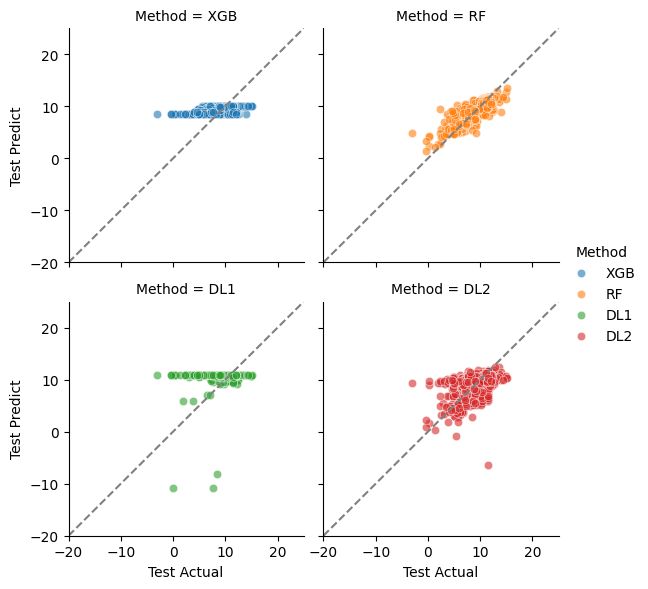

In [90]:
#%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = -20
x_max = 25
y_min, y_max = x_min, x_max


#width = 6; height = 6  # Define desired figure width and height in inches
#plt.figure(figsize=(width, height)) # Create the figure with specified size

#g = sns.FacetGrid(test_prediction, height = 6)
#sns.scatterplot(y="Test Predict", x="Test Actual",
#                hue ="Method", alpha = 0.6,
#                data = test_prediction)#,height = 6)#, edgecolor="w")
x = np.linspace(x_min, x_max, 100)
y = x

g = sns.FacetGrid(test_prediction, col="Method", col_wrap=2, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))
g.add_legend()

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

In [91]:
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("http://commondatastorage.googleapis.com/codeskulptor-assets/Epoq-Lepidoptera.ogg").play()')

# Other2

In [92]:
df2.to_csv("2024-01-03 Psat Psat SMILES T VP.csv")

test_prediction.to_csv("2024-01-03 Psat Psat test_prediction.csv")
train_prediction.to_csv("2024-01-03 Psat Psat train_prediction.csv")
result_evaluation.to_csv("2024-01-03 Psat Psat result_evaluation.csv")

In [93]:
from joblib import dump, load

dump(all_result_model[0], "2024-01-03 Psat Psat XGB.joblib")
dump(all_result_model[1], "2024-01-03 Psat Psat RF.joblib")
torch.save(all_result_model[2].state_dict(), "2024-01-03 Psat Psat DL1.pth")
torch.save(all_result_model[3].state_dict(), "2024-01-03 Psat Psat DL2.pth")

#loaded_model = load("my_model.joblib")


# Visualization Additional

In [100]:
import pandas as pd
test_prediction = pd.read_csv("/content/2024-01-03 Psat Psat test_prediction.csv")
train_prediction = pd.read_csv("/content/2024-01-03 Psat Psat train_prediction.csv")
result_evaluation = pd.read_csv("/content/2024-01-03 Psat Psat result_evaluation.csv")

#test_prediction = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat test_prediction.csv")
#train_prediction = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat train_prediction.csv")
#result_evaluation = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat result_evaluation.csv")

In [101]:
#test_prediction.join(result_evaluation, by="Method")
result_evaluation_merge = result_evaluation[["Method","Test RMSE", "Test R2"]]
merged_df = test_prediction.merge(result_evaluation_merge, on='Method', how='inner')  # Inner join
merged_df

,Unnamed: 0,Method,Test Predict,Test Actual,Test RMSE,Test R2
0,0,XGB,8.604116,7.281770,117.949447,-0.197928
1,0,XGB,10.142992,11.522677,117.949447,-0.197928
2,0,XGB,8.974430,11.521645,117.949447,-0.197928
3,0,XGB,9.825973,11.600644,117.949447,-0.197928
4,0,XGB,8.974430,9.183080,117.949447,-0.197928
...,...,...,...,...,...,...
7631,3,DL2,7.889034,9.106887,107.423134,0.006348
7632,3,DL2,10.382971,11.486897,107.423134,0.006348
7633,3,DL2,9.757310,11.972799,107.423134,0.006348
7634,3,DL2,8.247873,8.817230,107.423134,0.006348


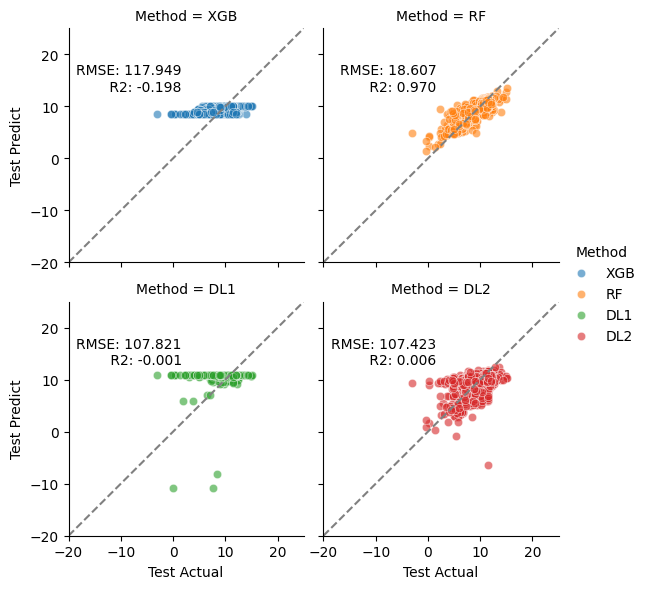

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = -20
x_max = 25
y_min, y_max = x_min, x_max

x = np.linspace(x_min, x_max, 100)
y = x

g = sns.FacetGrid(merged_df, col="Method", col_wrap=2, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)

def plot_with_text2(data, **kws):
    plt.axline((0, 0), slope=1, color='.5', linestyle='--')
    # Access the current subplot and add text
    current_ax = plt.gca()
    current_ax.text(0.5, 0.85, f"RMSE: {data['Test RMSE'].iloc[0]:.3f} \n R2: {data['Test R2'].iloc[0]:.3f} ",
                    transform=current_ax.transAxes, ha='right', va='top')
g.map_dataframe(plot_with_text2)
g.add_legend()

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()